# Concussion Claims Tracking

This analysis uses claims from the following classes:
- Non Marine Liability
- Marine Energy Liability
- iBott General Liability
- Specialty Disruption
- Accident & Health

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import scikit_vectorizer, PorterTokenizer, get_stopwords, sql_connection
from concussion import get_relevant_claims, get_full_claims_data
sns.set_theme(style="darkgrid")

In [2]:
key_words = ['concussion', 'cranial', 'brain',
             'head', 'headache', 'migraine', 'dizzy',
             'dizziness', 'fatigue', 'insomnia']

In [3]:
# Get Claims Data, format

engine = sql_connection('BASAPOPRDSQLV20', 'Apollo_Reporting')
df_scm = pd.read_sql_query("SELECT ClaimDetailID, ReceivedDate, LossDescription, LossLocation, HighestEstimate from V_LMMData_SCM", engine)
df_cgen = pd.read_sql_query("SELECT ClaimDetailID, ClaimAdvisedDate, HandlingClass, UnderwritingYear from V_ClaimData_General", engine)

df_scm_d = df_scm.sort_values(['ClaimDetailID', 'ReceivedDate'], axis=0).groupby('ClaimDetailID').tail(1)
df = df_scm_d.merge(df_cgen, how="left", on='ClaimDetailID')
df.columns = ['claim_id', 'received_date', 'documents', 'loss_location', 'highest_estimate','date', 'class', 'underwriting_year']
df = df[['date', 'underwriting_year', 'loss_location', 'claim_id', 'class', 'documents', 'highest_estimate']]
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

### Latest Claim Advised Date:

In [4]:
df_cgen.ClaimAdvisedDate.max()

Timestamp('2021-10-13 00:00:00')

In [8]:
# Get claims with key words in

stop_words_combined = get_stopwords()
vectorizer = scikit_vectorizer(stop_words_combined, PorterTokenizer, CountVectorizer)
relevant_claims, df_relevant_claims = get_relevant_claims(df, vectorizer)

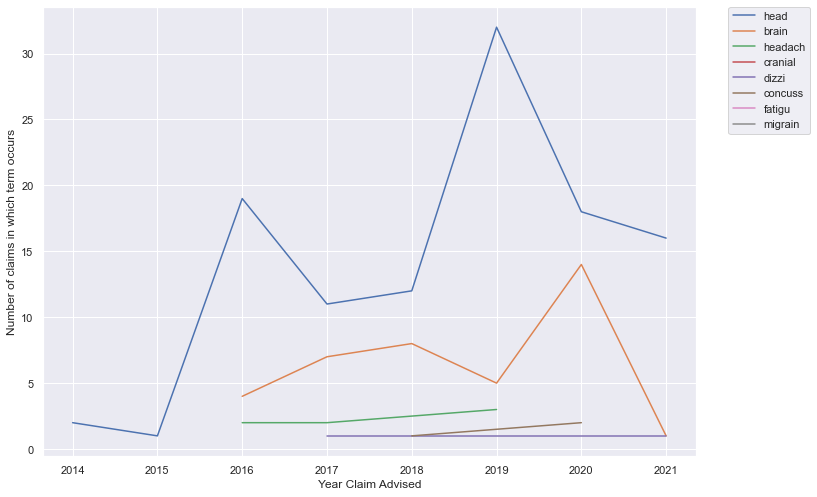

In [46]:
# Terms by Date Claim Advised

sns.set(rc={'figure.figsize':(11.7,8.27)})
graph_data_1 = relevant_claims.groupby([relevant_claims.date.dt.year,'term'], as_index=True).sum().reset_index()
ax = sns.lineplot(x=graph_data_1.date, y=graph_data_1.mentions, hue=graph_data_1.term)
ax.set(xlabel='Year Claim Advised', ylabel='Number of claims in which term occurs')
plt.pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

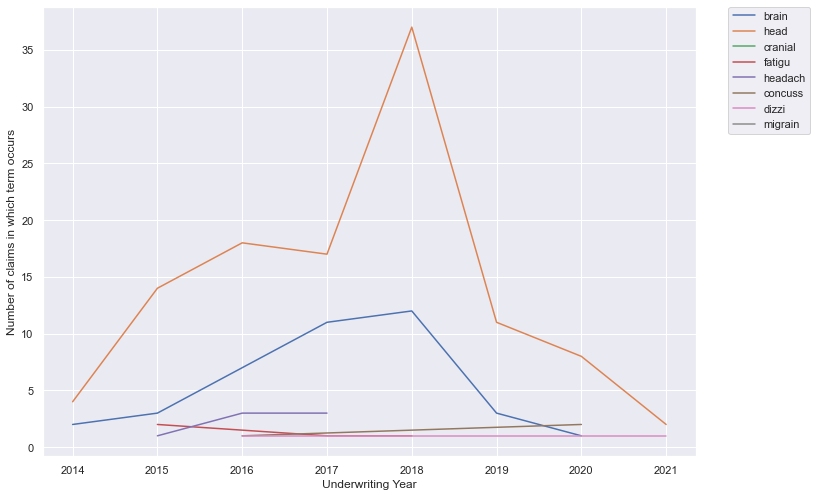

In [47]:
# Terms by Underwriting Year

graph_data_2 = relevant_claims.groupby([relevant_claims.underwriting_year,'term'], as_index=True).sum().reset_index()
ax = sns.lineplot(x=graph_data_2.underwriting_year, y=graph_data_2.mentions, hue=graph_data_2.term)
ax.set(xlabel='Underwriting Year', ylabel='Number of claims in which term occurs')
plt.pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
# Full claims data for relative numbers

df_claims = get_full_claims_data(df_scm, df_cgen, relevant_claims)

In [12]:
# Number of flagged claims relative to total - Advised Date

graph_data_3 = df_claims.groupby([df_claims.ClaimAdvisedDate.dt.year, 'relevant_claim'], as_index=True).count().drop('ClaimAdvisedDate', axis=1).reset_index()
x = pd.pivot_table(graph_data_3, values='ClaimDetailID', index='ClaimAdvisedDate', columns='relevant_claim')
x['relevant_perc'] = 100*x['Relevant']/x['Irrelevant']
x

relevant_claim,Irrelevant,Relevant,relevant_perc
ClaimAdvisedDate,,,
2010,19.0,NaN,NaN
2011,50.0,NaN,NaN
2012,50.0,NaN,NaN
2013,52.0,NaN,NaN
2014,157.0,2.0,1.273885
2015,568.0,1.0,0.176056
2016,1956.0,24.0,1.226994
2017,3513.0,21.0,0.597780
2018,4239.0,26.0,0.613352


In [21]:
# Number of flagged claims relative to total - UW Year

graph_data_4 = df_claims.groupby([df_claims.UnderwritingYear, 'relevant_claim'], as_index=True).count().reset_index()
x = pd.pivot_table(graph_data_4, values='ClaimDetailID', index='UnderwritingYear', columns='relevant_claim')
x['relevant_perc'] = 100*x['Relevant']/x['Irrelevant']
x

relevant_claim,Irrelevant,Relevant,relevant_perc
UnderwritingYear,,,
2010.0,121.0,NaN,NaN
2011.0,106.0,NaN,NaN
2012.0,91.0,NaN,NaN
2013.0,191.0,NaN,NaN
2014.0,729.0,6.0,0.823045
2015.0,2870.0,20.0,0.696864
2016.0,4994.0,30.0,0.600721
2017.0,5267.0,32.0,0.607556
2018.0,5885.0,50.0,0.849618


In [34]:
# Cost of flagged claims relative to total - Advised Date

graph_data_5 = df_claims.groupby([df_claims.ClaimAdvisedDate.dt.year, 'relevant_claim'], as_index=True).mean().reset_index()
pd.pivot_table(graph_data_5, values='HighestEstimate', index='ClaimAdvisedDate', columns='relevant_claim')
graph_data_5.head()

,ClaimAdvisedDate,relevant_claim,ClaimDetailID,HighestEstimate,UnderwritingYear
0,2010,Irrelevant,311.421053,743075.526316,2010.000000
1,2011,Irrelevant,17323.860000,316404.052800,2010.100000
2,2012,Irrelevant,8862.460000,521384.454800,2011.020000
3,2013,Irrelevant,9114.173077,251753.187000,2011.480769
4,2014,Irrelevant,14240.299363,373092.938193,2013.121019


In [31]:
# Cost of flagged claims relative to total - UW Year

graph_data_6 = df_claims.groupby([df_claims.UnderwritingYear, 'relevant_claim'], as_index=True).agg({'ClaimDetailID':'count','HighestEstimate':'sum'}).reset_index()
graph_data_6['avg_claim_cost'] = graph_data_6.HighestEstimate/graph_data_6.ClaimDetailID
pd.pivot_table(graph_data_6, values='avg_claim_cost', index='UnderwritingYear', columns='relevant_claim')

relevant_claim,Irrelevant,Relevant
UnderwritingYear,,
2010.0,3.406065e+05,NaN
2011.0,3.034087e+05,NaN
2012.0,4.312868e+05,NaN
2013.0,2.099611e+05,NaN
2014.0,1.608468e+05,2.975759e+04
2015.0,7.287765e+05,7.554964e+04
2016.0,1.091918e+06,1.916519e+06
2017.0,9.131324e+05,1.570965e+04
2018.0,3.311713e+05,4.224220e+02


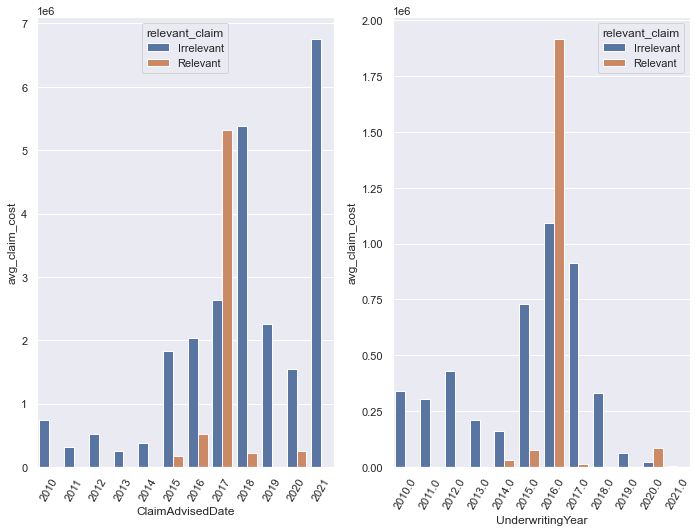

In [49]:
fig, ax = plt.pyplot.subplots(1,2)
sns.barplot(x=graph_data_5['ClaimAdvisedDate'], y=graph_data_5['HighestEstimate'], hue=graph_data_5['relevant_claim'], ax=ax[0])
sns.barplot(x=graph_data_6['UnderwritingYear'], y=graph_data_6['avg_claim_cost'], hue=graph_data_6['relevant_claim'], ax=ax[1])
ax[0].set(ylabel='avg_claim_cost')
ax[0].tick_params(axis='x', rotation=60)
ax[1].tick_params(axis='x', rotation=60)